In [7]:
import pandas as pd

In [47]:
df = pd.read_csv("data/train.csv")

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   dt                400 non-null    object
 1   Цена на арматуру  400 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 6.4+ KB


In [50]:
df.describe()

,Цена на арматуру
count,400.000000
mean,39229.475000
std,13407.979668
min,21000.000000
25%,31075.000000
50%,35450.000000
75%,42000.000000
max,79000.000000


In [115]:
df_train = df['Цена на арматуру'].iloc[:-150]
df_test = df['Цена на арматуру'].iloc[-150:]

In [116]:
df_train

0      32900
1      32500
2      32000
3      30700
4      30300
       ...  
245    36200
246    35000
247    34200
248    33500
249    33300
Name: Цена на арматуру, Length: 250, dtype: int64

In [63]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [119]:
from statsmodels.tsa.ar_model import AutoReg
model = AutoReg(df_train, lags=97).fit()
# best_score = [-1000, -1]
# for i in range(99):
#     model = AutoReg(df_train, lags=i).fit()
#     forecasts = model.forecast(150).tolist()
#     if r2_score(forecasts, df_test) > best_score[0]:
#         best_score = [r2_score(forecasts, df_test), i]
# print(best_score)

In [120]:
y = model.forecast(150).tolist()

In [121]:
print('R2 score:', r2_score(y, df_test))
print('MSE score:', mean_squared_error(y, df_test))
print('MAE score:', mean_absolute_error(y, df_test))

R2 score: -18.72543821065157
MSE score: 204293194.79146335
MAE score: 12183.329743155133


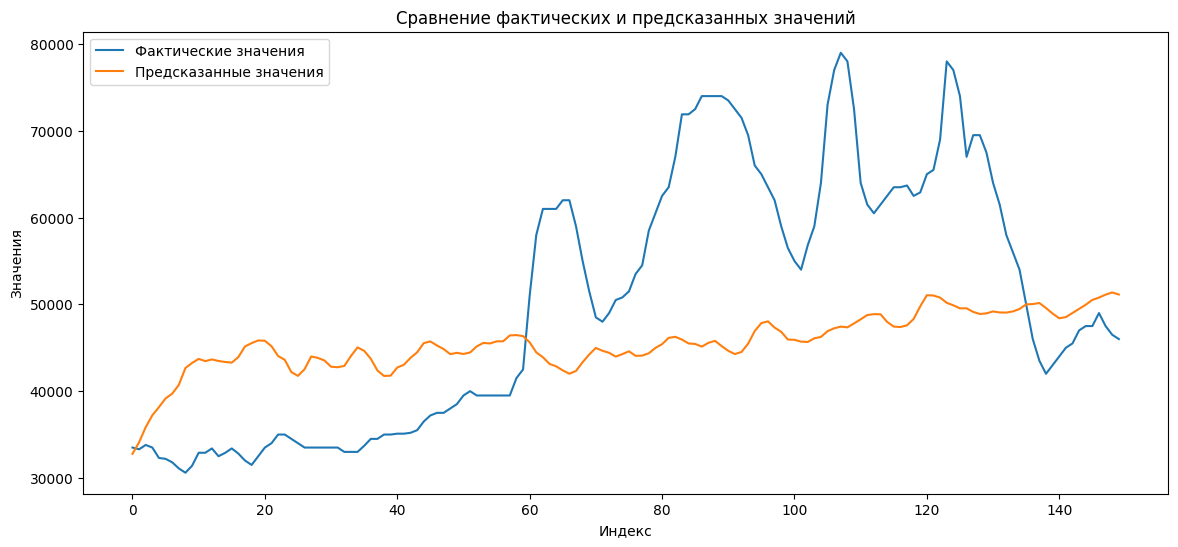

In [126]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 6))
if isinstance(df_test, (pd.Series, pd.DataFrame)):
    df_test_reset = df_test.reset_index(drop=True)
else:
    df_test_reset = pd.Series(df_test)
plt.plot(df_test_reset, label='Фактические значения')
plt.plot(y, label='Предсказанные значения')
plt.title('Сравнение фактических и предсказанных значений')
plt.xlabel('Индекс')
plt.ylabel('Значения')
plt.legend()
plt.show()